# Evaluation

In [9]:
import json
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from dinov2.models.vision_transformer import DinoVisionTransformer, vit_large
from dinov2.models.vision_transformer import vit_base
from torchvision.transforms import ToTensor,ToPILImage

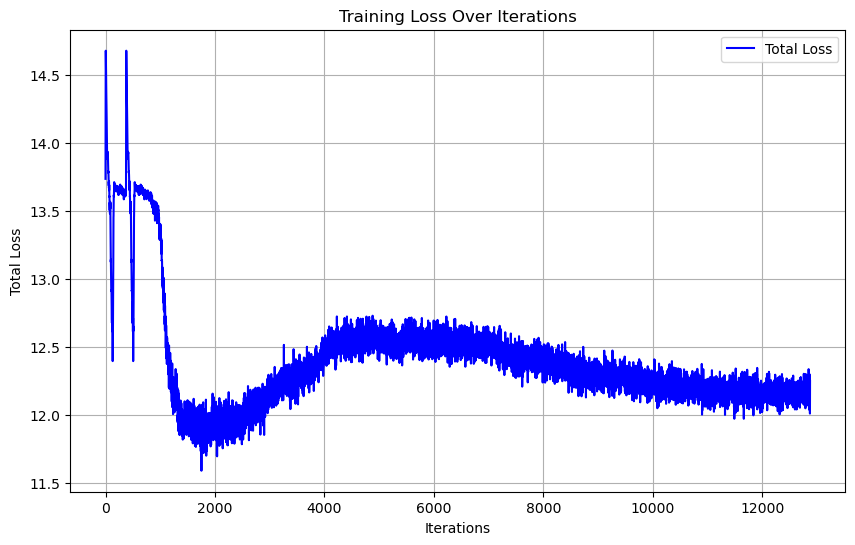

In [3]:
metrics_file = "./CelebA_gt/training_metrics.json"

with open(metrics_file, "r") as file:
    metrics = [json.loads(line) for line in file]

iterations = range(len(metrics))
total_loss = [entry["total_loss"] for entry in metrics]

plt.figure(figsize=(10, 6))
plt.plot(iterations, total_loss, label="Total Loss", color="blue")
plt.xlabel("Iterations")
plt.ylabel("Total Loss")
plt.title("Training Loss Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

**Comment:** Loss curve is similar to: https://github.com/facebookresearch/dinov2/issues/143#issuecomment-1651732518
TODO: Perform knn- and linear evaluation for each teacher checkpoint and plot the results. Then compare it with image retrieval performance.

## Loading Customly Pre-Trained DINOv2 Model

In [17]:
# !pip install omegaconf

In [18]:
from dinov2.utils.config import get_cfg_from_args
from dinov2.utils.utils import load_pretrained_weights
from dinov2.models import build_model, build_model_from_cfg

In [21]:
class Args:
    def __init__(self, config_file, output_dir=None, opts=None):
        self.config_file = config_file
        self.output_dir = output_dir or ""
        self.opts = opts or []

In [22]:
args = Args(config_file="./CelebA_gt/config.yaml")
cfg = get_cfg_from_args(args)
model, _ = build_model_from_cfg(cfg, only_teacher=True)
pretrained_weights = './CelebA_gt/eval/training_124999/teacher_checkpoint.pth'
load_pretrained_weights(model, pretrained_weights, "teacher")
model.eval()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): BlockChunk(
      (0-5): 6 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (l